In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Get a list of column names and types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Climate Analysis

2016-08-23


C:\Users\Jenni\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


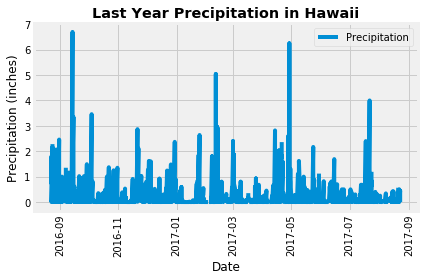

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Find the last date in our data
last_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
one_year = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year)

# Perform a query to retrieve the data and precipitation scores
last_yr_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= str(one_year), Measurement.date <= '2017-08-23').\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_yr_prcp_df = pd.DataFrame(last_yr_prcp, columns=['Date', 'Precipitation'])

# Sort the dataframe by date.
last_yr_prcp_df['Date'] = pd.to_datetime(last_yr_prcp_df['Date'])

# Use Pandas Plotting with Matplotlib to plot the data.
plt.plot(last_yr_prcp_df['Date'], last_yr_prcp_df['Precipitation'])
plt.legend(loc='best')
plt.title('Last Year Precipitation in Hawaii', fontweight="bold")
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')

# Rotate x axis ticks 90 grades.
plt.xticks(rotation='90')

plt.tight_layout()
plt.show()
#plt.savefig("Images/PrecipitationDatePlot.png")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_yr_prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
print(f'There are {stations} stations available in this dataset.')

There are 9 stations available in this dataset.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations =  session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

most_active_station = active_stations[0][0]

session.query(*sel).filter(Measurement.station==most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

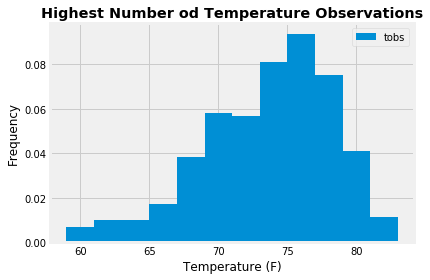

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobsData = session.query(Measurement.tobs).\
                filter(Measurement.date >= one_year).\
                filter(Measurement.station == most_active_station).\
                order_by(Measurement.date.desc()).all()

x = [x[0] for x in tobsData]

# Plot the results as a histogram
plt.hist(x, bins=12, density=True, label=Measurement.tobs.name)
plt.title('Highest Number od Temperature Observations', fontweight="bold")
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.legend(prop={'size':10})

plt.tight_layout()
plt.show()
#plt.savefig("Images/HighestNumberTobs.png")

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2016-11-12', '2016-11-21')
trip_temp

[(68.0, 75.56666666666666, 80.0)]

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [25]:
# Plot the daily normals as an area plot with `stacked=False`
